In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
sys.path.append(os.path.dirname(os.getcwd())) # Include ../SSD in path
!pwd

/Users/mariu/dev/school/TDT4265/project/computer-vision-and-deep-learning/SSD/notebooks


In [3]:
# Only necessary to run this on local machine
# ['/data', '/dataset_exploration', '/datasets', '/demo', '']
%cd ../

/Users/mariu/dev/school/TDT4265/project/computer-vision-and-deep-learning/src/SSD


In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from vizer.draw import draw_boxes
from tops.config import instantiate, LazyConfig
from ssd import utils
np.random.seed(0)

In [5]:
from dataset_exploration.dataset_statistics import (
    statistics,
    analyze_distribution,
    analyze_bounding_boxes,
    get_config,
    get_dataloader,
)

In [6]:
# Load config
config_path = "/Users/mariu/dev/school/TDT4265/project/computer-vision-and-deep-learning/src/SSD/configs/tdt4265.py"
cfg = get_config(config_path)

Saving SSD outputs to: outputs/


In [7]:
label_map = cfg.label_map
print(f"Label map is: {label_map}")

Label map is: {0: 'background', 1: 'car', 2: 'truck', 3: 'bus', 4: 'motorcycle', 5: 'bicycle', 6: 'scooter', 7: 'person', 8: 'rider'}


In [9]:
# Get dataloader
dataset_to_analyze = "train"
dataloader = get_dataloader(cfg, dataset_to_analyze)

In [25]:
# dir(dataloader_train)

all_training_images = list(dataloader.dataset)

In [10]:
data = next(iter(dataloader))

In [11]:
data.keys()

dict_keys(['image', 'boxes', 'labels', 'width', 'height', 'image_id'])

In [12]:
next_image = next(iter(dataloader))
print(f"Feature batch shape: {next_image['image'].size()}")
print(f"Labels batch shape: {next_image['labels'].size()}")

Feature batch shape: torch.Size([1, 3, 128, 1024])
Labels batch shape: torch.Size([1, 14])


Shape: torch.Size([3, 128, 1024])


TypeError: Invalid shape (3, 128, 1024) for image data

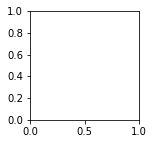

In [13]:
# Display image and label.
img = next_image['image'][0]
im2display = img #.permute(1, 2, 0)
print(f'Shape: {im2display.shape}')
label = next_image['labels'][0]
fig, ax = plt.subplots(figsize=(18, 2))
ax.imshow(im2display, cmap="gray")

In [14]:
# Draw bounding boxes
dataset_to_visualize = "train"

if dataset_to_visualize == "train":
    # Remove GroundTruthBoxesToAnchors transform
    if cfg.data_train.dataset._target_ == torch.utils.data.ConcatDataset:
        for dataset in cfg.data_train.dataset.datasets:
            dataset.transform.transforms = dataset.transform.transforms[:-1]
        else:
            cfg.data_train.dataset.transform.transforms = cfg.data_train.dataset.transform.transforms[:-1]
        dataset = instantiate(cfg.data_train.dataloader)
        gpu_transform = instantiate(cfg.data_train.gpu_transform)
    else:
        cfg.data_val.dataloader.collate_fn = utils.batch_collate
        dataset = instantiate(cfg.data_val.dataloader)
        gpu_transform = instantiate(cfg.data_val.gpu_transform)

# Assumes taht the first GPU transform is Normalize
# If it fails, just change the index from 0.
image_mean = torch.tensor(cfg.data_train.gpu_transform.transforms[0].mean).view(1, 3, 1, 1)
image_std = torch.tensor(cfg.data_train.gpu_transform.transforms[0].std).view(1, 3, 1, 1)

In [15]:
sample = next(iter(dataset))
sample = gpu_transform(sample)

In [16]:
print(f"The first sample in the dataset the following keys: {sample.keys()}")
for key, item in sample.items():
    print(key, ": shape=", item.shape if hasattr(item, "shape") else "", 
          " dtype=", item.dtype if hasattr(item, "dtype") else type(item), sep="")

The first sample in the dataset the following keys: dict_keys(['image', 'boxes', 'labels', 'width', 'height', 'image_id'])
image: shape=torch.Size([1, 3, 128, 1024]) dtype=torch.float32
boxes: shape=torch.Size([1, 14, 4]) dtype=torch.float32
labels: shape=torch.Size([1, 14]) dtype=torch.int64
width: shape=torch.Size([1]) dtype=torch.int64
height: shape=torch.Size([1]) dtype=torch.int64
image_id: shape=torch.Size([1]) dtype=torch.int64


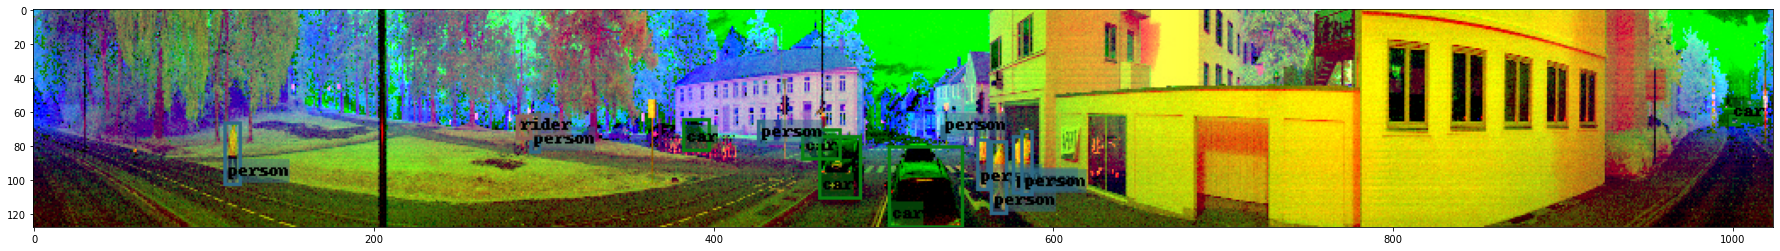

In [17]:
# Convert image to HWC byte
image = (sample["image"] * image_std + image_mean)
image = (image * 255).byte()[0]
im = image.permute(1, 2, 0).cpu().numpy()

# Convert boxes to pixel coordinates
boxes = sample["boxes"][0]
boxes[:, [0, 2]] *= image.shape[-1]  # width
boxes[:, [1, 3]] *= image.shape[-2]  # height

# Draw boxes on image, params: image, boxes with pixel coordinates, label value, label names.
im_with_boxes = draw_boxes(im, boxes.cpu().numpy(), sample["labels"][0].cpu().numpy().tolist(), class_name_map=cfg.label_map)

concat_im = np.concatenate([im, im_with_boxes], axis=0)

#fig, ax = plt.subplot(figsize=(18, 2))
#plt.imshow(im)
fig, ax = plt.subplots(figsize=(36, 4))
ax.imshow(im_with_boxes)
#plt.show()